## 0. Constants

In [1]:
BOOKINGS_DATA = "../data/customer_booking.csv"

---
## 1. Imports

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()

import sklearn
from sklearn.feature_selection import mutual_info_classif
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score

from xgboost import XGBClassifier

In [3]:
df = pd.read_csv(BOOKINGS_DATA, encoding="ISO-8859-1")
df.head()

,num_passengers,sales_channel,trip_type,purchase_lead,length_of_stay,flight_hour,flight_day,route,booking_origin,wants_extra_baggage,wants_preferred_seat,wants_in_flight_meals,flight_duration,booking_complete
0,2,Internet,RoundTrip,262,19,7,Sat,AKLDEL,New Zealand,1,0,0,5.52,0
1,1,Internet,RoundTrip,112,20,3,Sat,AKLDEL,New Zealand,0,0,0,5.52,0
2,2,Internet,RoundTrip,243,22,17,Wed,AKLDEL,India,1,1,0,5.52,0
3,1,Internet,RoundTrip,96,31,4,Sat,AKLDEL,New Zealand,0,0,1,5.52,0
4,2,Internet,RoundTrip,68,22,15,Wed,AKLDEL,India,1,0,1,5.52,0


---
## 2. EDA

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 14 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   num_passengers         50000 non-null  int64  
 1   sales_channel          50000 non-null  object 
 2   trip_type              50000 non-null  object 
 3   purchase_lead          50000 non-null  int64  
 4   length_of_stay         50000 non-null  int64  
 5   flight_hour            50000 non-null  int64  
 6   flight_day             50000 non-null  object 
 7   route                  50000 non-null  object 
 8   booking_origin         50000 non-null  object 
 9   wants_extra_baggage    50000 non-null  int64  
 10  wants_preferred_seat   50000 non-null  int64  
 11  wants_in_flight_meals  50000 non-null  int64  
 12  flight_duration        50000 non-null  float64
 13  booking_complete       50000 non-null  int64  
dtypes: float64(1), int64(8), object(5)
memory usage: 5.3+ 

In [5]:
df.describe()

,num_passengers,purchase_lead,length_of_stay,flight_hour,wants_extra_baggage,wants_preferred_seat,wants_in_flight_meals,flight_duration,booking_complete
count,50000.000000,50000.000000,50000.00000,50000.00000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000
mean,1.591240,84.940480,23.04456,9.06634,0.668780,0.296960,0.427140,7.277561,0.149560
std,1.020165,90.451378,33.88767,5.41266,0.470657,0.456923,0.494668,1.496863,0.356643
min,1.000000,0.000000,0.00000,0.00000,0.000000,0.000000,0.000000,4.670000,0.000000
25%,1.000000,21.000000,5.00000,5.00000,0.000000,0.000000,0.000000,5.620000,0.000000
50%,1.000000,51.000000,17.00000,9.00000,1.000000,0.000000,0.000000,7.570000,0.000000
75%,2.000000,115.000000,28.00000,13.00000,1.000000,1.000000,1.000000,8.830000,0.000000
max,9.000000,867.000000,778.00000,23.00000,1.000000,1.000000,1.000000,9.500000,1.000000


In [6]:
#Check unique values of object columns
object_cols = df.select_dtypes(include="object")
for col in object_cols:
    print(f"{col} unique values:\n")
    print(df[col].unique())
    print("\n", "-"*20)

sales_channel unique values:

['Internet' 'Mobile']

 --------------------
trip_type unique values:

['RoundTrip' 'CircleTrip' 'OneWay']

 --------------------
flight_day unique values:

['Sat' 'Wed' 'Thu' 'Mon' 'Sun' 'Tue' 'Fri']

 --------------------
route unique values:

['AKLDEL' 'AKLHGH' 'AKLHND' 'AKLICN' 'AKLKIX' 'AKLKTM' 'AKLKUL' 'AKLMRU'
 'AKLPEK' 'AKLPVG' 'AKLTPE' 'AORICN' 'AORKIX' 'AORKTM' 'AORMEL' 'BBIMEL'
 'BBIOOL' 'BBIPER' 'BBISYD' 'BDOCTS' 'BDOCTU' 'BDOHGH' 'BDOICN' 'BDOIKA'
 'BDOKIX' 'BDOMEL' 'BDOOOL' 'BDOPEK' 'BDOPER' 'BDOPUS' 'BDOPVG' 'BDOSYD'
 'BDOTPE' 'BDOXIY' 'BKICKG' 'BKICTS' 'BKICTU' 'BKIHND' 'BKIICN' 'BKIKIX'
 'BKIKTM' 'BKIMEL' 'BKIMRU' 'BKIOOL' 'BKIPEK' 'BKIPER' 'BKIPUS' 'BKIPVG'
 'BKISYD' 'BKIXIY' 'BLRICN' 'BLRMEL' 'BLRPER' 'BLRSYD' 'BOMMEL' 'BOMOOL'
 'BOMPER' 'BOMSYD' 'BTJJED' 'BTUICN' 'BTUPER' 'BTUSYD' 'BTUWUH' 'BWNCKG'
 'BWNDEL' 'BWNHGH' 'BWNIKA' 'BWNKTM' 'BWNMEL' 'BWNOOL' 'BWNPER' 'BWNSYD'
 'BWNTPE' 'CANDEL' 'CANIKA' 'CANMEL' 'CANMRU' 'CANOOL' 'CANPER' 'CA

In [7]:
df.route.nunique()

799

In [8]:
df.booking_origin.nunique()

104

In [9]:
#Check for any duplications
df.duplicated().sum()

719

In [10]:
df = df.drop_duplicates()

In [11]:
df.duplicated().sum()

0

In [12]:
#Check the distribution of the target
df.booking_complete.value_counts()

0    41890
1     7391
Name: booking_complete, dtype: int64

---
# 3. Processing

In [13]:
mapping = {
    "Mon": 1,
    "Tue": 2,
    "Wed": 3,
    "Thu": 4,
    "Fri": 5,
    "Sat": 6,
    "Sun": 7,
}

df["flight_day"] = df["flight_day"].map(mapping)

In [14]:
X= df.drop('booking_complete',axis=1)
y= df.booking_complete         

#changing object dtype to int dtype
for colname in X.select_dtypes("object"):
    X[colname], _ = X[colname].factorize()

In [15]:
X.head()

,num_passengers,sales_channel,trip_type,purchase_lead,length_of_stay,flight_hour,flight_day,route,booking_origin,wants_extra_baggage,wants_preferred_seat,wants_in_flight_meals,flight_duration
0,2,0,0,262,19,7,6,0,0,1,0,0,5.52
1,1,0,0,112,20,3,6,0,0,0,0,0,5.52
2,2,0,0,243,22,17,3,0,1,1,1,0,5.52
3,1,0,0,96,31,4,6,0,0,0,0,1,5.52
4,2,0,0,68,22,15,3,0,1,1,0,1,5.52


In [16]:
X.dtypes

num_passengers             int64
sales_channel              int64
trip_type                  int64
purchase_lead              int64
length_of_stay             int64
flight_hour                int64
flight_day                 int64
route                      int64
booking_origin             int64
wants_extra_baggage        int64
wants_preferred_seat       int64
wants_in_flight_meals      int64
flight_duration          float64
dtype: object

In [17]:
mi_scores = mutual_info_classif(X, y)
mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
mi_scores = mi_scores.sort_values(ascending=False)

mi_scores 

route                    0.051643
booking_origin           0.048056
flight_duration          0.016456
length_of_stay           0.008437
wants_extra_baggage      0.007625
flight_hour              0.004044
wants_in_flight_meals    0.003361
purchase_lead            0.003063
num_passengers           0.001674
wants_preferred_seat     0.001541
flight_day               0.001488
sales_channel            0.000724
trip_type                0.000000
Name: MI Scores, dtype: float64

Text(0.5, 1.0, 'Mutual Information Scores')

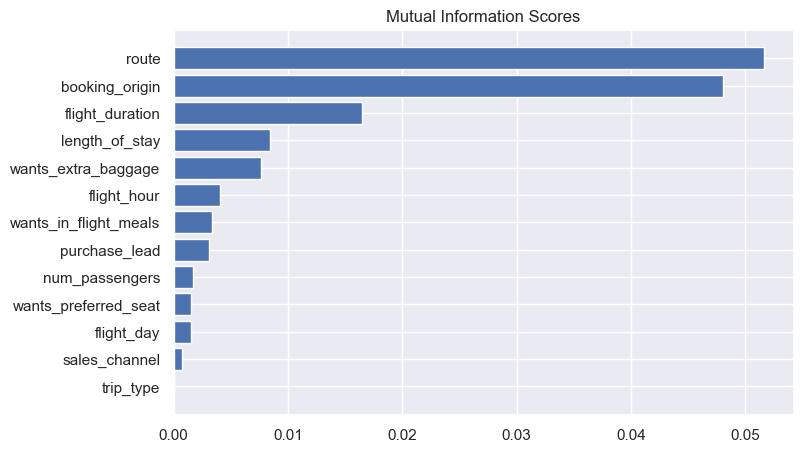

In [18]:
plt.figure(figsize=(8, 5))
mi_scores = mi_scores.sort_values(ascending=True)
height = range(len(mi_scores))
ticks = list(mi_scores.index)
plt.barh(height, mi_scores)
plt.yticks(height, ticks)
plt.title("Mutual Information Scores")

---
# 4. Model Development

In [19]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state = 11)

## 4.1 Random Forrest

### 4.1.1 Random forest classifier with top 6 features

In [20]:
features=['route','booking_origin','flight_duration','wants_extra_baggage', 'length_of_stay','num_passengers']

X_train_6 = X_train[features]
X_test_6 = X_test[features]

In [21]:
rf_clf= RandomForestClassifier(random_state=1)
rf_clf.fit(X_train_6, y_train)
preds= rf_clf.predict(X_test_6)

print('ACCURACY: ',accuracy_score(y_test,preds)*100)
print('AUC score: ',roc_auc_score(y_test,preds))

ACCURACY:  83.07801562341484
AUC score:  0.5737534928017463


### 4.1.2 Random forest classifier with all features

In [22]:
rf_clf= RandomForestClassifier(random_state=1)
rf_clf.fit(X_train, y_train)
preds= rf_clf.predict(X_test)

print('ACCURACY: ',accuracy_score(y_test,preds)*100)
print('AUC score: ',roc_auc_score(y_test,preds))

ACCURACY:  85.3099320280004
AUC score:  0.5422987082942716


## 4.2 XGBoost

### 4.2.1 XGBoost classifier with top 6 features

In [23]:
xgb_model = XGBClassifier()

xgb_model.fit(X_train_6, y_train)
prediction_xgb = xgb_model.predict(X_test_6)
print('ACCURACY: ',accuracy_score(y_test, prediction_xgb)*100)
print('AUC score: ',roc_auc_score(y_test,prediction_xgb))    

ACCURACY:  85.28964187886781
AUC score:  0.5355315057543831


### 4.2.2 XGBoost classifier with all features

In [24]:
xgb_model = XGBClassifier()

xgb_model.fit(X_train, y_train)
prediction_xgb = xgb_model.predict(X_test)
print('ACCURACY: ',accuracy_score(y_test, prediction_xgb)*100)
print('AUC score: ',roc_auc_score(y_test,prediction_xgb))    

ACCURACY:  84.87369382164958
AUC score:  0.5397458704885247
